# Road Signs Bounding Box Prediction using PyTorch

<b>Problem Statement:</b> Predict bounding box around a Road sign in a given image and also predict the type of road sign.

<b>Dataset:</b> https://www.kaggle.com/andrewmvd/road-sign-detection 

(title= Road Signs Dataset ,<br>
url= https://makeml.app/datasets/road-signs,<br>
journal= Make ML)<br>


In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#!unzip road_signs.zip

## Loading the data

In [4]:
data_dir = '../data/OnlyOneAlfaLaval'
images_path = Path('../data/OnlyOneAlfaLaval')
anno_path = Path('../data/OnlyOneAlfaLaval/annotations')

In [5]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [6]:
df_train = generate_train_df(anno_path)

In [7]:
#label encode target
class_dict = {'alfa': 0}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [8]:
print(df_train.shape)
df_train.head()

(180, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,..\data\OnlyOneAlfaLaval\Alfa_Laval_Sensor_000...,1280,720,0,459,219,477,238
1,..\data\OnlyOneAlfaLaval\Alfa_Laval_Sensor_001...,1280,720,0,445,211,465,233
2,..\data\OnlyOneAlfaLaval\Alfa_Laval_Sensor_002...,1280,720,0,430,203,447,223
3,..\data\OnlyOneAlfaLaval\Alfa_Laval_Sensor_003...,1280,720,0,459,196,478,217
4,..\data\OnlyOneAlfaLaval\Alfa_Laval_Sensor_004...,1280,720,0,463,188,482,211


## Resizing images and bounding boxes

In [9]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [10]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [11]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [12]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path(f'{data_dir}/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

### Sample Image

In [13]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(720, 1280, 3)


In [14]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([268., 467., 292., 487.], dtype=float32)

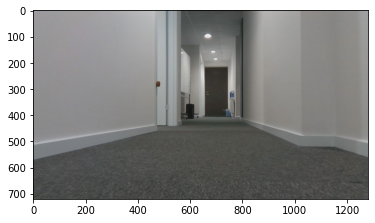

In [15]:
plt.imshow(im)

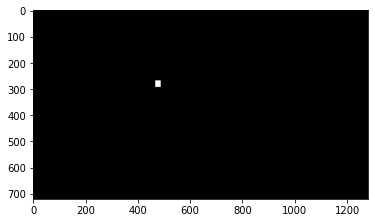

In [16]:
plt.imshow(Y, cmap='gray')

## Data augmentation

Functions in this section borrowed and modified from https://www.usfca.edu/data-institute/certificates/fundamentals-deep-learning 

In [17]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


In [18]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [19]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

### Sample Image

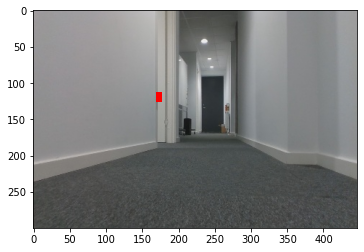

In [20]:
#original
im = cv2.imread(str(df_train.values[60][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[60][9])

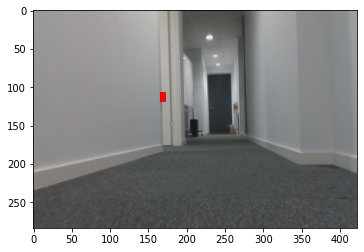

In [21]:
# after transformation
im, bb = transformsXY(str(df_train.values[60][8]),df_train.values[60][9],True )
show_corner_bb(im, bb)

## Train-valid split

In [22]:
df_train = df_train.reset_index()

In [23]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

## Dataset

In [25]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [26]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [27]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [28]:
batch_size = 8
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

## Model

In [29]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

## Training

In [30]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [38]:
train_ouputs = []
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        train_ouputs.append({'val_loss': val_loss, 'val_acc': val_acc})
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total


In [32]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [33]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [34]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=25)

train_loss 2.254 val_loss 7144.566 val_acc 0.000
train_loss 0.856 val_loss 0.607 val_acc 1.000
train_loss 0.564 val_loss 0.418 val_acc 1.000
train_loss 0.455 val_loss 0.326 val_acc 1.000
train_loss 0.359 val_loss 0.271 val_acc 1.000
train_loss 0.316 val_loss 0.290 val_acc 1.000
train_loss 0.311 val_loss 0.297 val_acc 1.000
train_loss 0.300 val_loss 0.283 val_acc 1.000
train_loss 0.296 val_loss 0.319 val_acc 1.000
train_loss 0.307 val_loss 0.353 val_acc 1.000
train_loss 0.307 val_loss 0.271 val_acc 1.000
train_loss 0.300 val_loss 0.347 val_acc 1.000
train_loss 0.291 val_loss 0.391 val_acc 1.000
train_loss 0.314 val_loss 0.297 val_acc 1.000
train_loss 0.297 val_loss 0.487 val_acc 1.000
train_loss 0.280 val_loss 0.311 val_acc 1.000
train_loss 0.282 val_loss 0.248 val_acc 1.000
train_loss 0.286 val_loss 0.402 val_acc 1.000
train_loss 0.280 val_loss 0.269 val_acc 1.000
train_loss 0.288 val_loss 0.340 val_acc 1.000
train_loss 0.275 val_loss 0.244 val_acc 1.000
train_loss 0.262 val_loss 0.277

0.26394426822662354

In [35]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

train_loss 0.256 val_loss 0.224 val_acc 1.000
train_loss 0.238 val_loss 0.198 val_acc 1.000
train_loss 0.239 val_loss 0.193 val_acc 1.000
train_loss 0.226 val_loss 0.203 val_acc 1.000
train_loss 0.225 val_loss 0.192 val_acc 1.000
train_loss 0.215 val_loss 0.210 val_acc 1.000
train_loss 0.213 val_loss 0.171 val_acc 1.000
train_loss 0.215 val_loss 0.202 val_acc 1.000
train_loss 0.206 val_loss 0.173 val_acc 1.000
train_loss 0.195 val_loss 0.165 val_acc 1.000


0.19503187139829

### Making predictions

In [36]:
# choose random image from validation set
X_val

,new_path,new_bb
19,..\data\OnlyOneAlfaLaval\images_resized\Alfa_L...,"[59.0, 283.0, 68.0, 291.0]"
42,..\data\OnlyOneAlfaLaval\images_resized\Alfa_L...,"[34.0, 109.0, 59.0, 126.0]"
153,..\data\OnlyOneAlfaLaval\images_resized\Alfa_L...,"[212.0, 41.0, 239.0, 66.0]"
78,..\data\OnlyOneAlfaLaval\images_resized\Alfa_L...,"[187.0, 73.0, 203.0, 86.0]"
145,..\data\OnlyOneAlfaLaval\images_resized\Alfa_L...,"[189.0, 113.0, 209.0, 127.0]"
15,..\data\OnlyOneAlfaLaval\images_resized\Alfa_L...,"[56.0, 225.0, 75.0, 240.0]"
24,..\data\OnlyOneAlfaLaval\images_resized\Alfa_L...,"[4.0, 341.0, 21.0, 352.0]"
68,..\data\OnlyOneAlfaLaval\images_resized\Alfa_L...,"[175.0, 160.0, 184.0, 167.0]"
113,..\data\OnlyOneAlfaLaval\images_resized\Alfa_L...,"[163.0, 122.0, 179.0, 137.0]"
118,..\data\OnlyOneAlfaLaval\images_resized\Alfa_L...,"[163.0, 51.0, 191.0, 78.0]"


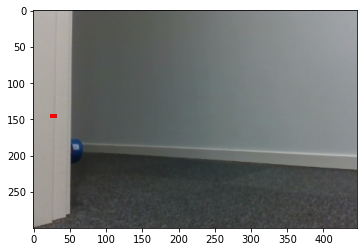

In [45]:
# resizing test image
num='123'
im = read_image(f'{data_dir}/images_resized/Alfa_Laval_Sensor_{num}.jpg')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite(f'{data_dir}/AlfaLavalTest/Alfa_Laval_Sensor_{num}.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':f'{data_dir}/AlfaLavalTest/Alfa_Laval_Sensor_{num}.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape

# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

# predicted class
torch.max(out_class, 1)

# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])